# 使用 XGBoost 预测英雄联盟获胜

本笔记本使用 Kaggle 数据集 [英雄联盟排名比赛](https://www.kaggle.com/paololol/league-of-legends-ranked-matches)，其中包含从 2014 年开始的 180,000 场英雄联盟排名比赛。 根据这些数据，我们构建了一个 XGBoost 模型，根据有关该球员比赛表现的统计数据来预测该球员的球队是否会获胜。

这里使用的方法适用于任何数据集。 我们使用此数据集来说明 SHAP 值如何帮助使梯度增强树（例如 XGBoost）可解释。 由于数据集的大小、交互作用、包含分类和连续特征及其可解释性（特别是对于游戏玩家），该数据集适合作为各个方面的一个很好的例子。 有关 SHAP 值的更多信息，请参阅：https://github.com/shap/shap

In [1]:
from pathlib import Path

import matplotlib.pyplot as pl
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split

import shap

d:\work\miniconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 加载数据集

要自己运行此程序，您需要从 Kaggle 下载数据集并确保下面的“前缀”变量正确。 为此，请点击上面给出的链接并下载并提取数据。 如果需要，更改“前缀”变量。

In [2]:
# read in the data
folder_path = Path("./data/league-of-legends-ranked-matches/")
matches = pd.read_csv(folder_path / "matches.csv")
participants = pd.read_csv(folder_path / "participants.csv")
stats1 = pd.read_csv(folder_path / "stats1.csv", low_memory=False)
stats2 = pd.read_csv(folder_path / "stats2.csv", low_memory=False)
stats = pd.concat([stats1, stats2])

# merge into a single DataFrame
a = pd.merge(
    participants, matches, left_on="matchid", right_on="id", suffixes=("", "_matches")
)
allstats_orig = pd.merge(
    a, stats, left_on="matchid", right_on="id", suffixes=("", "_stats")
)
allstats = allstats_orig.copy()

# drop games that lasted less than 10 minutes
allstats = allstats.loc[allstats["duration"] >= 10 * 60, :]

# Convert string-based categories to numeric values
cat_cols = ["role", "position", "version", "platformid"]
for c in cat_cols:
    allstats[c] = allstats[c].astype("category")
    allstats[c] = allstats[c].cat.codes
allstats["wardsbought"] = allstats["wardsbought"].astype(np.int32)

X = allstats.drop(columns=["win"])
y = allstats["win"]

# convert all features we want to consider as rates
rate_features = [
    "kills",
    "deaths",
    "assists",
    "killingsprees",
    "doublekills",
    "triplekills",
    "quadrakills",
    "pentakills",
    "legendarykills",
    "totdmgdealt",
    "magicdmgdealt",
    "physicaldmgdealt",
    "truedmgdealt",
    "totdmgtochamp",
    "magicdmgtochamp",
    "physdmgtochamp",
    "truedmgtochamp",
    "totheal",
    "totunitshealed",
    "dmgtoobj",
    "timecc",
    "totdmgtaken",
    "magicdmgtaken",
    "physdmgtaken",
    "truedmgtaken",
    "goldearned",
    "goldspent",
    "totminionskilled",
    "neutralminionskilled",
    "ownjunglekills",
    "enemyjunglekills",
    "totcctimedealt",
    "pinksbought",
    "wardsbought",
    "wardsplaced",
    "wardskilled",
]
for feature_name in rate_features:
    X[feature_name] /= X["duration"] / 60  # per minute rate

# convert to fraction of game
X["longesttimespentliving"] /= X["duration"]

# define friendly names for the features
full_names = {
    "kills": "Kills per min.",
    "deaths": "Deaths per min.",
    "assists": "Assists per min.",
    "killingsprees": "Killing sprees per min.",
    "longesttimespentliving": "Longest time living as % of game",
    "doublekills": "Double kills per min.",
    "triplekills": "Triple kills per min.",
    "quadrakills": "Quadra kills per min.",
    "pentakills": "Penta kills per min.",
    "legendarykills": "Legendary kills per min.",
    "totdmgdealt": "Total damage dealt per min.",
    "magicdmgdealt": "Magic damage dealt per min.",
    "physicaldmgdealt": "Physical damage dealt per min.",
    "truedmgdealt": "True damage dealt per min.",
    "totdmgtochamp": "Total damage to champions per min.",
    "magicdmgtochamp": "Magic damage to champions per min.",
    "physdmgtochamp": "Physical damage to champions per min.",
    "truedmgtochamp": "True damage to champions per min.",
    "totheal": "Total healing per min.",
    "totunitshealed": "Total units healed per min.",
    "dmgtoobj": "Damage to objects per min.",
    "timecc": "Time spent with crown control per min.",
    "totdmgtaken": "Total damage taken per min.",
    "magicdmgtaken": "Magic damage taken per min.",
    "physdmgtaken": "Physical damage taken per min.",
    "truedmgtaken": "True damage taken per min.",
    "goldearned": "Gold earned per min.",
    "goldspent": "Gold spent per min.",
    "totminionskilled": "Total minions killed per min.",
    "neutralminionskilled": "Neutral minions killed per min.",
    "ownjunglekills": "Own jungle kills per min.",
    "enemyjunglekills": "Enemy jungle kills per min.",
    "totcctimedealt": "Total crown control time dealt per min.",
    "pinksbought": "Pink wards bought per min.",
    "wardsbought": "Wards bought per min.",
    "wardsplaced": "Wards placed per min.",
    "turretkills": "# of turret kills",
    "inhibkills": "# of inhibitor kills",
    "dmgtoturrets": "Damage to turrets",
}
feature_names = [full_names.get(n, n) for n in X.columns]
X.columns = feature_names

# create train/validation split
Xt, Xv, yt, yv = train_test_split(X, y, test_size=0.2, random_state=10)
dt = xgb.DMatrix(Xt, label=yt.values)
dv = xgb.DMatrix(Xv, label=yv.values)

## 训练 XGBoost 模型

In [3]:
params = {
    "objective": "binary:logistic",
    "base_score": np.mean(yt),
    "eval_metric": "logloss",
}
model = xgb.train(
    params,
    dt,
    num_boost_round=10,
    evals=[(dt, "train"), (dv, "valid")],
    early_stopping_rounds=5,
    verbose_eval=25,
)

[0]	train-logloss:0.57255	valid-logloss:0.57258
[9]	train-logloss:0.34293	valid-logloss:0.34323


## 解释XGBoost模型

由于 Tree SHAP 算法是在 XGBoost 中实现的，因此我们可以快速计算数千个样本的精确 SHAP 值。 单个预测的 SHAP 值（包括最后一列中的预期输出）总和为该预测的模型输出。

In [4]:
# compute the SHAP values for every prediction in the validation dataset
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xv)

### 解释单个玩家赢得特定比赛的机会

SHAP 值的总和等于模型的预期输出与当前玩家的当前输出之间的差值。 请注意，对于 Tree SHAP 实现，解释的是模型的边际输出，而不是转换后的输出（例如逻辑回归的概率）。 这意味着该模型的 SHAP 值的单位是对数优势比。 较大的正值意味着玩家可能会获胜，而较大的负值意味着他们可能会失败。

In [5]:
shap.force_plot(explainer.expected_value, shap_values[0, :], Xv.iloc[0, :])

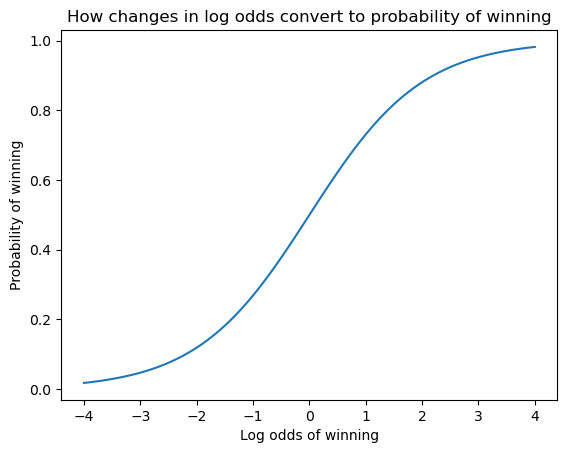

In [6]:
xs = np.linspace(-4, 4, 100)
pl.xlabel("Log odds of winning")
pl.ylabel("Probability of winning")
pl.title("How changes in log odds convert to probability of winning")
pl.plot(xs, 1 / (1 + np.exp(-xs)))
pl.show()

### 总结所有特征对整个数据集的影响

特定预测的特征的 SHAP 值表示当我们观察该特征时模型预测的变化程度。 在下面的汇总图中，我们将单个特征（例如“goldearned”）的所有 SHAP 值绘制成一行，其中 x 轴是 SHAP 值（对于该模型，以获胜的对数赔率为单位）。 通过对所有特征执行此操作，我们可以看到哪些特征对模型的预测有很大影响（例如“goldearned”），哪些特征对预测影响很小（例如“kills”）。 请注意，当点在线上不一致时，它们会垂直堆积以显示密度。 每个点也根据该特征的值从高到低进行着色。

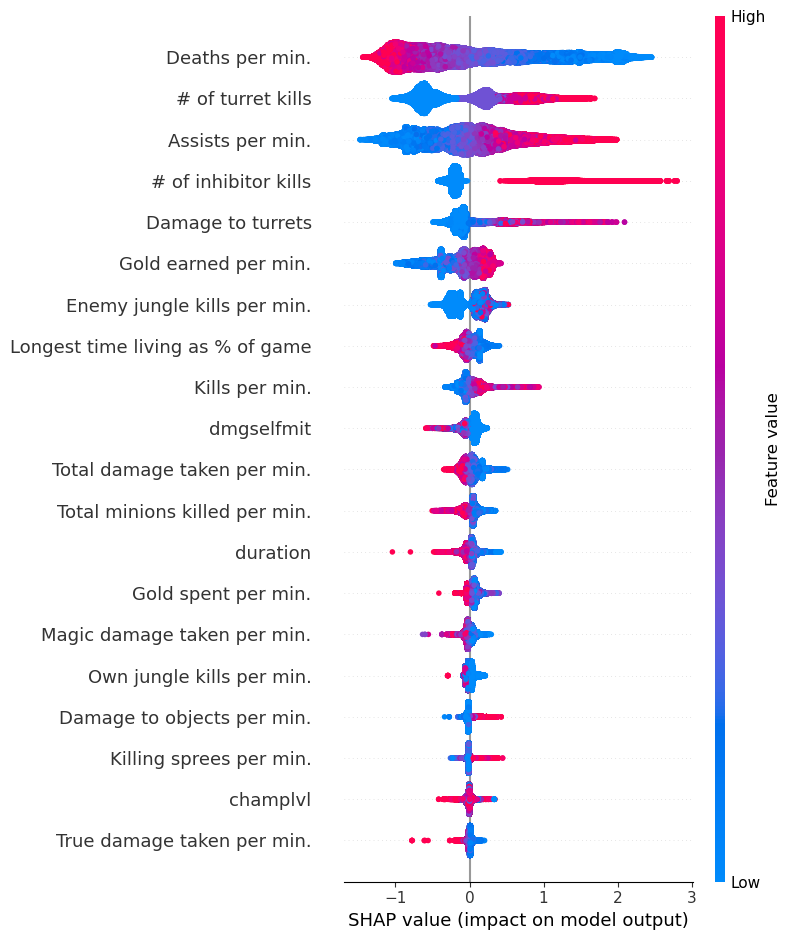

In [7]:
shap.summary_plot(shap_values, Xv)

## 检查特征的变化如何改变模型的预测

我们上面训练的 XGBoost 模型非常复杂，但是通过绘制某个特征的 SHAP 值与所有玩家的该特征的实际值，我们可以看到特征值的变化如何影响模型的输出。 请注意，这些图与标准部分依赖图非常相似，但它们提供了额外的优势，即显示上下文对于特征的重要性（或者换句话说，交互项的重要性）。 有多少交互项影响特征的重要性是通过数据点的垂直分散来捕获的。 例如，在游戏中每分钟仅赚取 100 金币可能会使某些玩家的获胜几率降低 10 倍，而另一些玩家则只会降低 3 倍。 为什么是这样？ 因为这些玩家的其他特征会影响赚取金币对于赢得游戏的重要性。 请注意，一旦您每分钟赚取至少 500 金币，垂直价差就会缩小，这意味着其他功能的背景对于高金币收入者而言不如低金币收入者那么重要。 我们用另一个最能解释交互效应方差的特征对数据点进行着色。 例如，如果你死得不多，赚到的金币少还不算太糟糕，但如果你也死了很多次，那就真的很糟糕了。

下图中的 y 轴代表该特征的 SHAP 值，因此 -4 表示观察该特征会将您的获胜对数几率降低 4，而值 +2 表示观察该特征会将您的获胜对数几率提高 2 。

请注意，这些图只是解释了 XGBoost 模型的工作原理，而不一定说明现实是如何工作的。 由于 XGBoost 模型是根据观察数据进行训练的，因此它不一定是因果模型，因此仅仅因为更改一个因素会使模型的获胜预测上升，并不总是意味着它会提高您的实际机会。

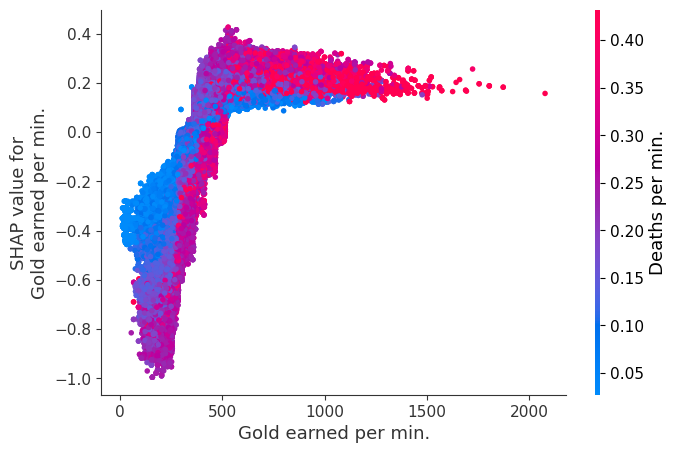

In [8]:
shap.dependence_plot(
    "Gold earned per min.", shap_values, Xv, interaction_index="Deaths per min."
)

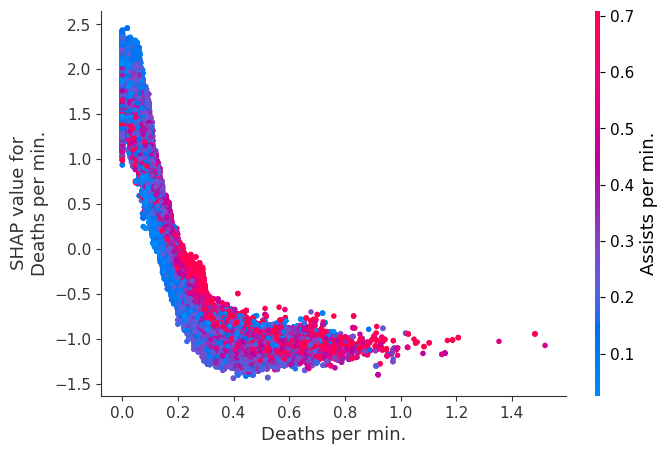

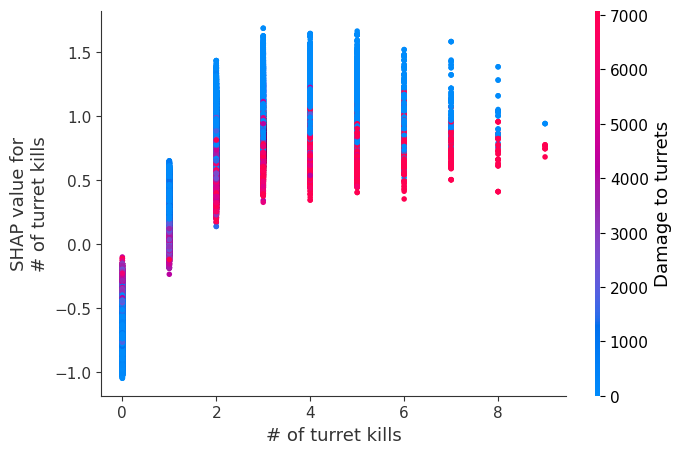

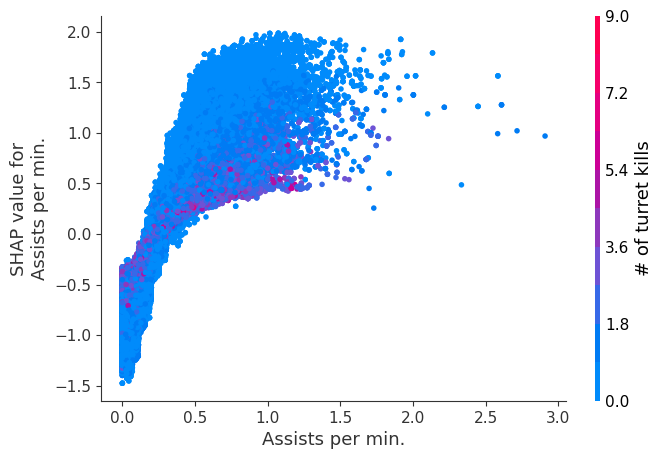

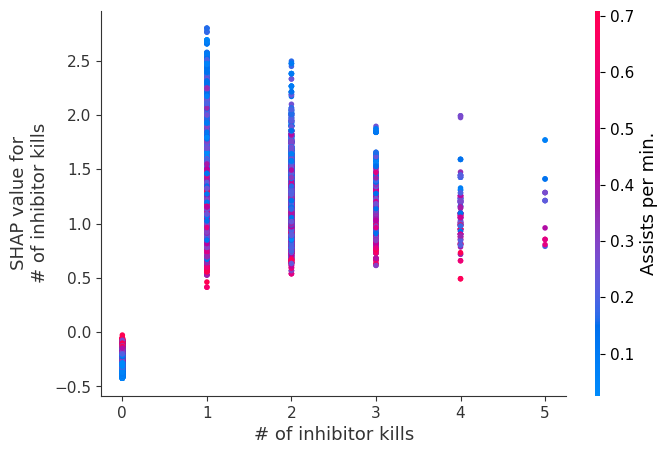

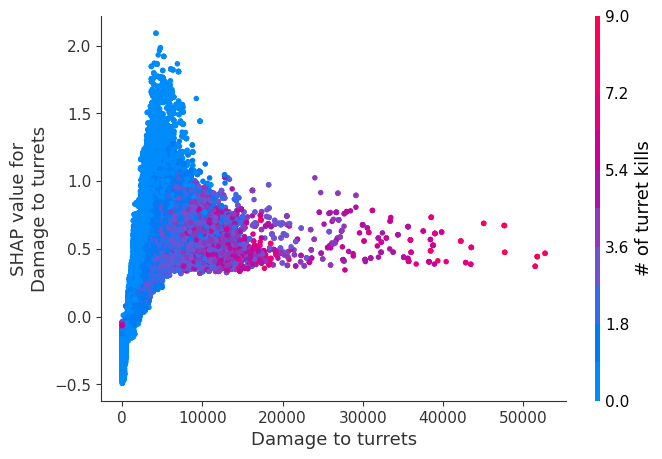

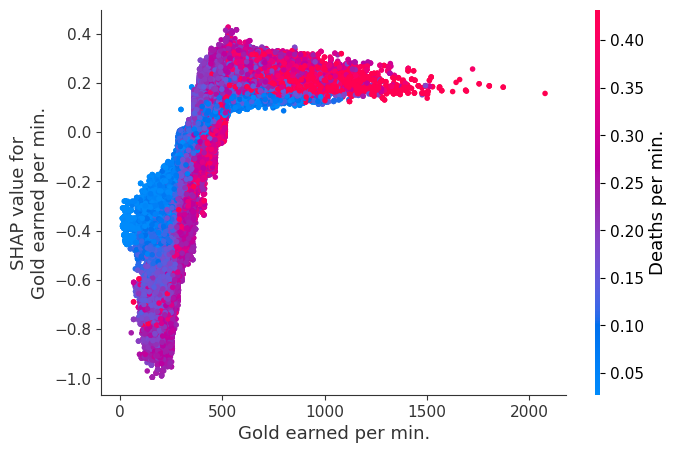

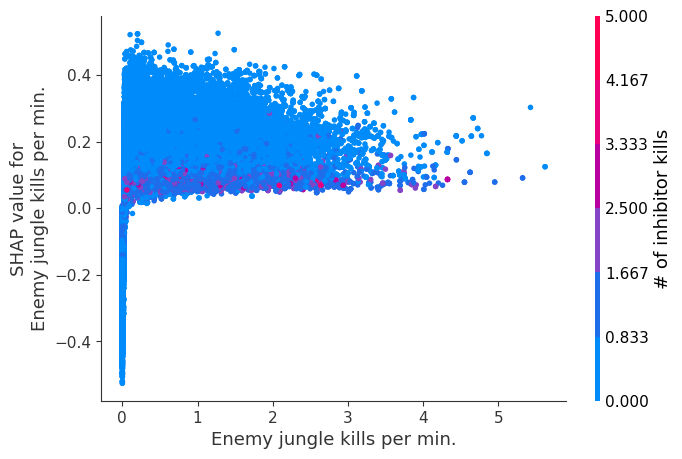

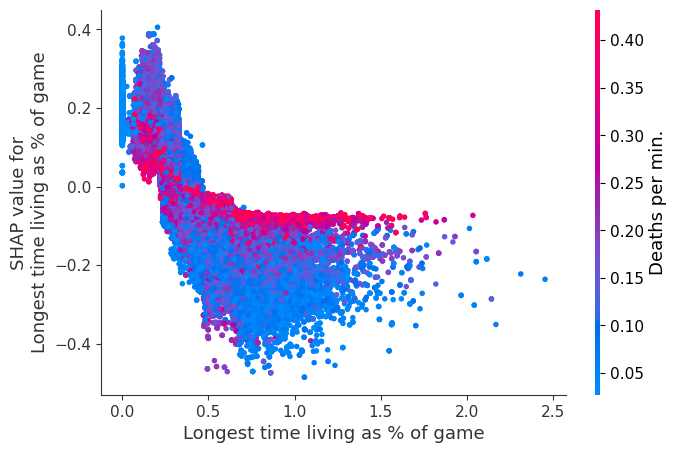

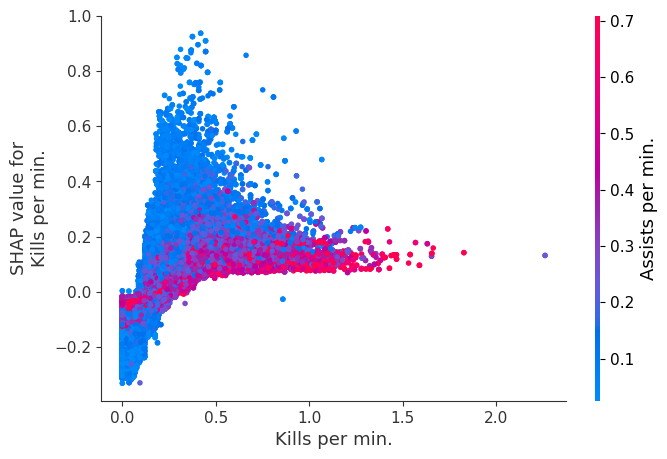

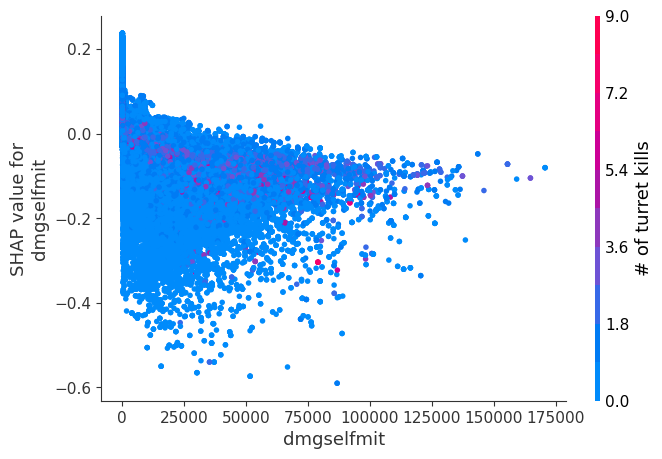

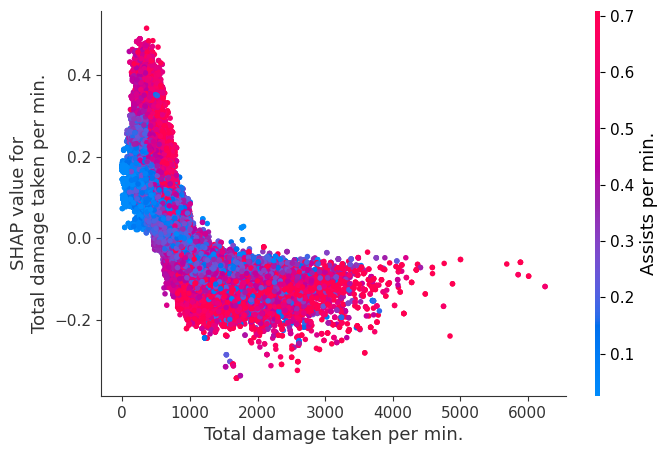

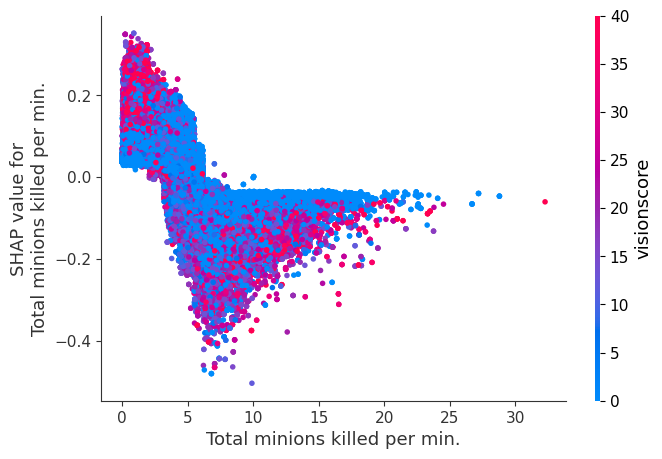

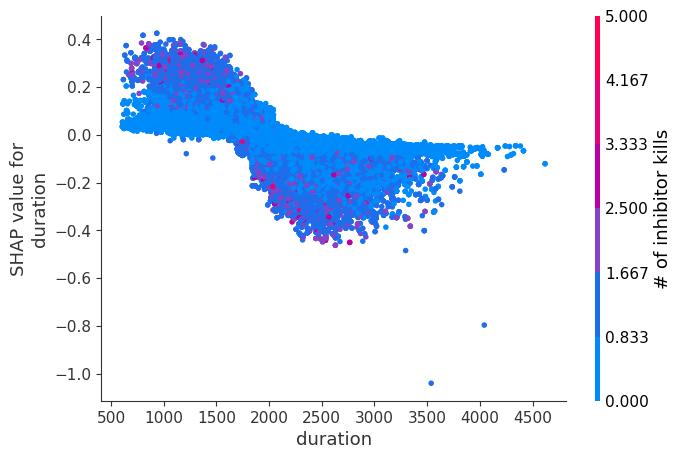

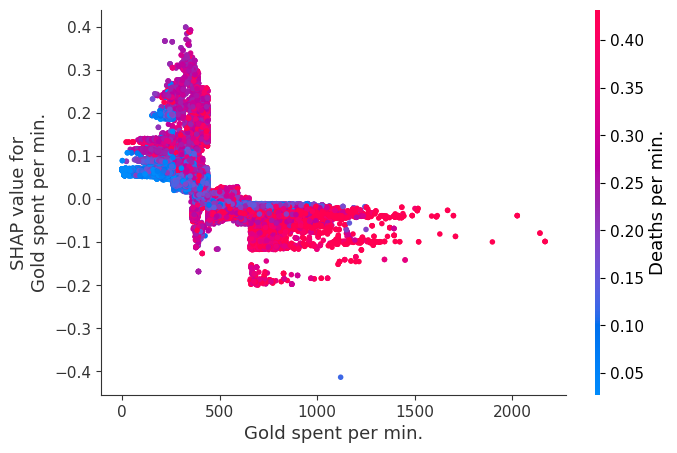

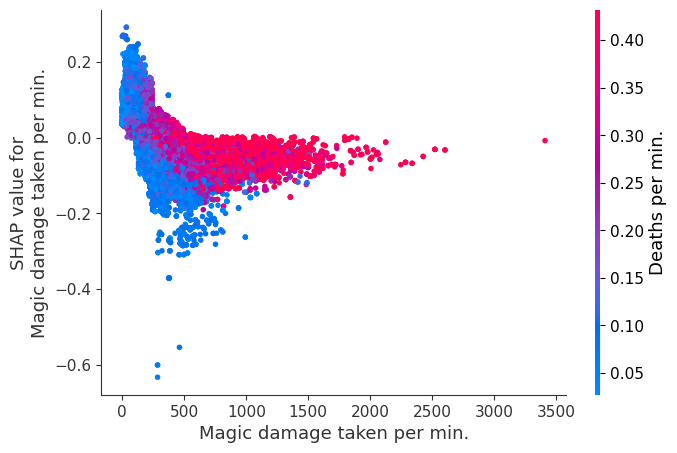

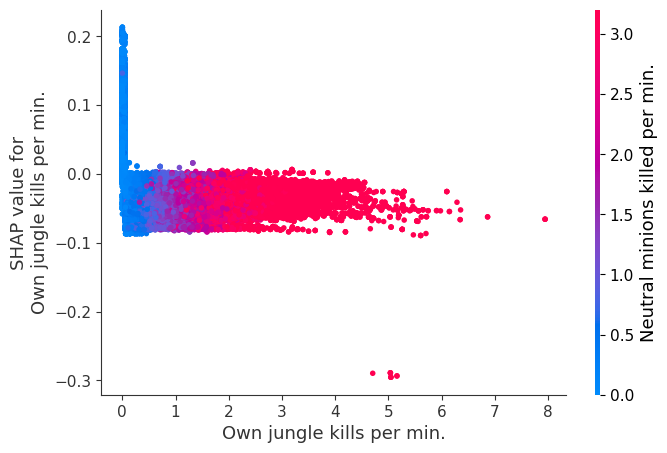

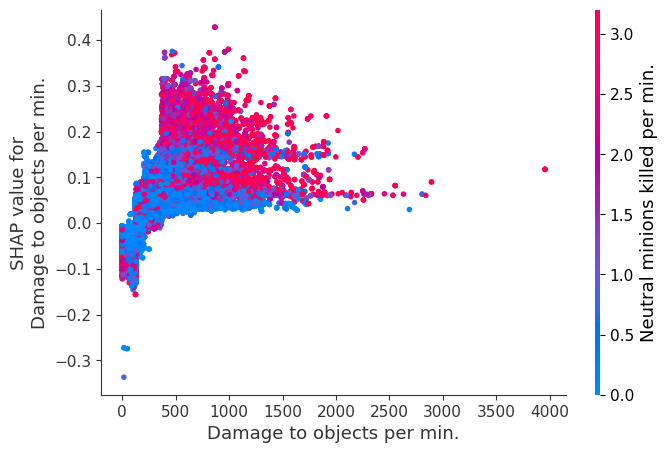

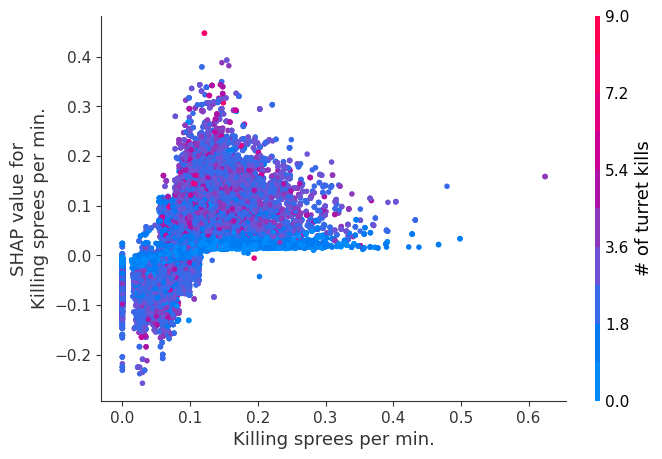

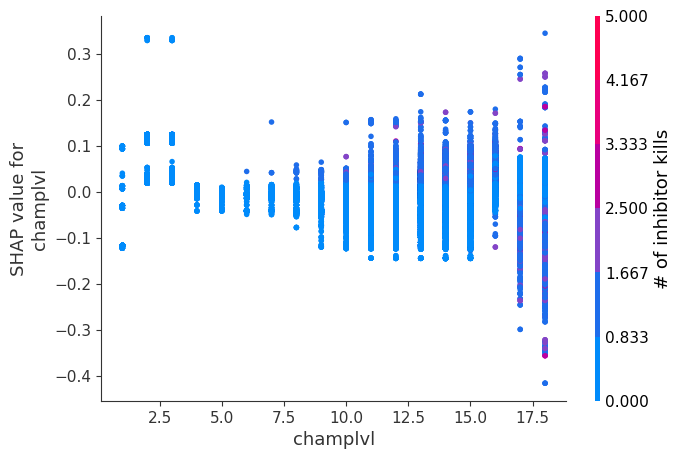

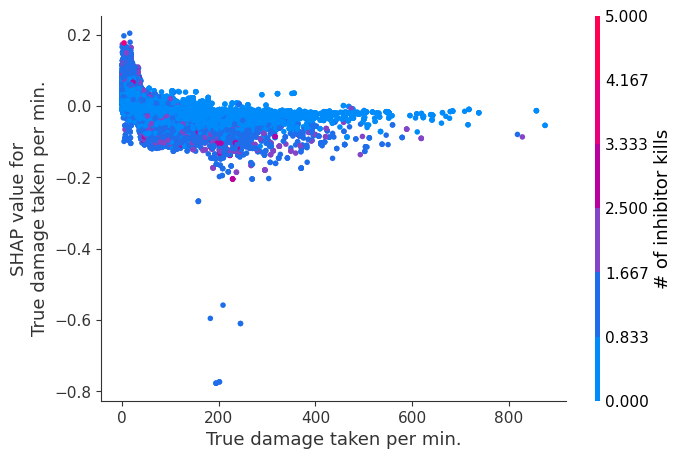

In [9]:
# sort the features indexes by their importance in the model
# (sum of SHAP value magnitudes over the validation dataset)
top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))

# make SHAP plots of the three most important features
for i in range(20):
    shap.dependence_plot(top_inds[i], shap_values, Xv)